In [1]:
import os
import sys
import numpy as np
import pandas as pd
import subprocess
import matplotlib as mpl
mpl.use('Agg')
import matplotlib.pyplot as plt
from matplotlib.legend_handler import HandlerLine2D
import itertools
from susipop import filter
from susipop import reader
from IPython.html.widgets import FloatProgress
from IPython.display import display
from ipywidgets import interactive, Layout
import ipywidgets as widgets
import scipy.stats as ss
import json
%matplotlib notebook
import parmap
from functools import partial
import multiprocessing 
import plotly
import susipop as sp
import pylab
from tqdm import tqdm
import warnings
from scipy import signal
warnings.filterwarnings('ignore')

/home/vsivadas/.local/lib/python2.7/site-packages/IPython/html.py:14: ShimWarning: The `IPython.html` package has been deprecated. You should import from `notebook` instead. `IPython.html.widgets` has moved to `ipywidgets`.
  "`IPython.html.widgets` has moved to `ipywidgets`.", ShimWarning)


In [277]:
def autocorr_normalized(x):
    """
    http://stackoverflow.com/q/14297012/190597
    http://en.wikipedia.org/wiki/Autocorrelation#Estimation
    """
    n = len(x)
    variance = x.var()
    x = x-x.mean()
    r = np.correlate(x, x, mode = 'full')
    result = r[-n:]
    result = r/(variance*(np.arange(n, 0, -1)))
    if np.isnan(np.min(result))  : result = np.nan_to_num(result)
    return result

def autocorr_not_normalized(x):
    corrs2 = np.correlate(x, x, mode='full')
    if np.isnan(np.min(corrs2))  : result = np.nan_to_num(corrs2)
    corrs2/= float(len(corrs2))
    return corrs2[corrs2.size//2:]

def autocorr_fft(sig):
    result = signal.fftconvolve(sig, sig[::-1], mode='full')
    result = result[result.size//2:]
    return result

    
tmin = -100



def calc_area(x,y):
    return np.trapz(y,x)

def calc_stuff(path,correltype=autocorr_not_normalized):
    print correltype
    try:
        dataset = sp.reader.DataSet(path,particles=True, fluid=False)
        timeseries = dataset.tlist[tmin:] 
        stress_timeseries = np.zeros((len(timeseries)))
        for i,t in enumerate(tqdm(timeseries,ascii=True,desc=path)):
            dataset.load_state(dataset.tlist[i])
            stress_on_particle = np.mean(map(np.linalg.norm,dataset.particles.sshear_tot))
            stress_timeseries[i] = stress_on_particle
        correl = correltype
        corrs = correl(stress_timeseries)

        return corrs
    except Exception as e:
        print e
        return [0,0]

def plot_acf_temporal(paths_input):
    global area_under_curves
    area_under_curves = [[],[]]
    paths = []
    for i in paths_input: 
        if os.path.exists(i):
            try:
                dataset = sp.reader.DataSet(i,particles=True, fluid=False)
                if len(dataset.tlist)>abs(tmin): 
                    paths.append(i)
            except: 
                continue
    try:
        pool = multiprocessing.Pool(len(paths))
        corrs_list = pool.map(calc_stuff, paths)
    finally:
        pool.close()
        pool.join()
    plt.figure(figsize=[12,10]) 
    plt.subplot(211)
    for i in range(len(paths)):
        if os.path.exists(paths[i]):
            plt.plot(corrs_list[i],label=paths[i])
            dataset = sp.reader.DataSet(paths[i],particles=True, fluid=False)
            area_under_curve = calc_area(np.multiply(dataset.tlist[tmin:],dataset.dt), corrs_list[i])
            area_under_curves[0].append(paths[i])
            area_under_curves[1].append(area_under_curve)
    plt.legend(loc="best",fontsize=10)
    plt.xlabel("lag")
    plt.ylabel("correlation")
    plt.yscale("log")
    plt.subplot(212)
    for path in paths_input:
        if os.path.exists(path+"result/nu_t.dat"):
            print path
            try:
                dataset = sp.reader.DataSet(path,particles=True, fluid=False)
                if len(dataset.tlist)>abs(tmin):
                    nu_file = pd.read_csv(path+"result/nu_t.dat")
                    nu_vals = nu_file[nu_file.columns[4]][tmin:]
#                     # print nu_vals
                    plt.plot(range(len(nu_vals)),nu_vals, label=path)
                    plt.xlabel("timestep")
                    plt.ylabel("rel.viscosity")
                    plt.yscale("log")
            except Exception as e:
                # print e
                continue
    plt.legend(loc='best',fontsize=10)
    plt.yscale("log")
#         plt.title("autocorrelation type: {}".format(correltype.__name__))
    plt.show()


<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>
<function autocorr_not_normalized at 0x2aab467447d0>


rhor1_phi56_yd30.0/: 100%|##########| 100/100 [00:07<00:00, 16.08it/s]


<IPython.core.display.Javascript object>


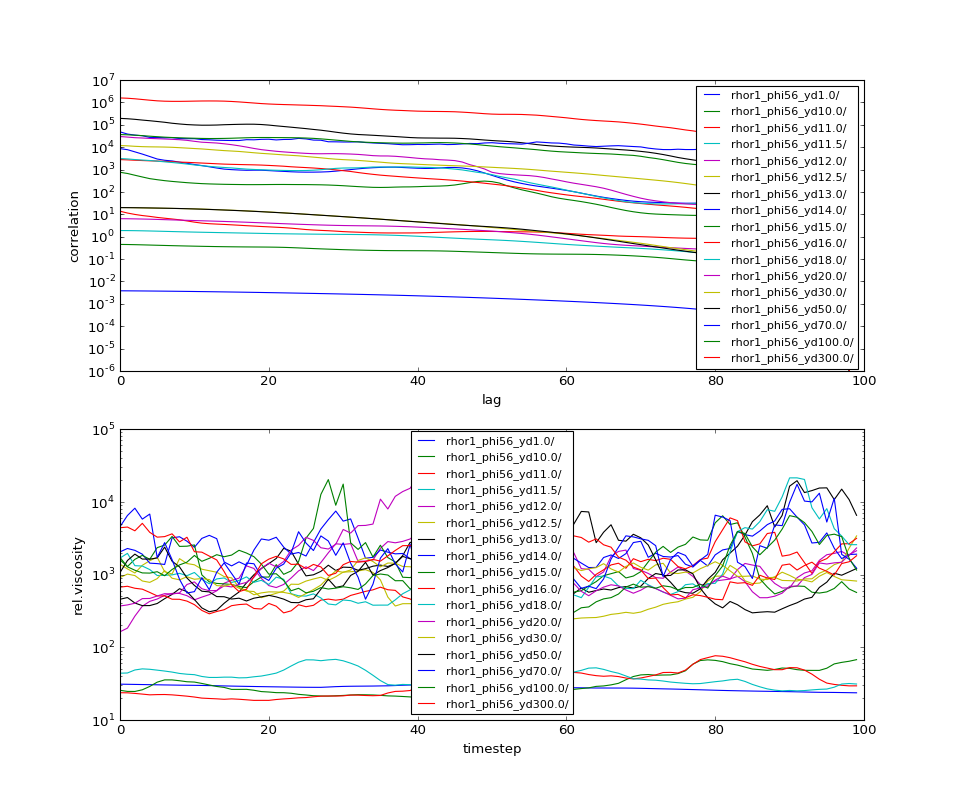

rhor1_phi56_yd1.0/
rhor1_phi56_yd10.0/
rhor1_phi56_yd11.0/
rhor1_phi56_yd11.5/
rhor1_phi56_yd12.0/
rhor1_phi56_yd12.5/
rhor1_phi56_yd13.0/
rhor1_phi56_yd14.0/
rhor1_phi56_yd15.0/
rhor1_phi56_yd16.0/
rhor1_phi56_yd18.0/
rhor1_phi56_yd20.0/
rhor1_phi56_yd30.0/
rhor1_phi56_yd50.0/
rhor1_phi56_yd70.0/
rhor1_phi56_yd100.0/
rhor1_phi56_yd300.0/


In [278]:
paths_input = ["rhor1_phi56_yd{}/".format(float(y)) for y in np.arange(1,1001,step=0.5)]
# paths_input = ["rhor1_phi56_yd{}/".format(float(y)) for y in [10.0,12.0,100.0]]
# paths_input = ["rhor1_phi56_yd{}/".format(float(y)) for y in [10.0,11.0,12.0,20.0,30.0,50.0]]
# paths_input = ["rhor1_phi56_yd{0}".format(y).split(',')]
# print paths_input
plot_acf_temporal(paths_input=paths_input)



['rhor1_phi56_yd11.0/', 'rhor1_phi56_yd11.5/', 'rhor1_phi56_yd12.0/', 'rhor1_phi56_yd12.5/', 'rhor1_phi56_yd13.0/', 'rhor1_phi56_yd14.0/', 'rhor1_phi56_yd16.0/', 'rhor1_phi56_yd18.0/', 'rhor1_phi56_yd20.0/', 'rhor1_phi56_yd30.0/', 'rhor1_phi56_yd50.0/', 'rhor1_phi56_yd100.0/', 'rhor1_phi56_yd300.0/']
[-0.00032833288044880845, -0.0059406557445061473, -0.0017390879278738338, -0.0019931990671390072, -0.0012910861583275536, -0.0024126451239704508, 0.0001143567233301006, 3.2694923308663943e-05, 0.00014010565116149689, -4.1539946091642579e-05, 4.6651092445412488e-05, -1.2116043566020112e-05, -5.050508113410237e-06]
[0.06433412990533921, 0.27820965082072663, 1.1768222402912372, 1.0822470198441672, 1.1835244365218003, 1.9907086615761103, 1.672793213845474, 1.5325992887492921, 2.535983035075092, 1.020866183175692, 1.747714195271358, 1.835106529163874, 1.7462059928841522]


<IPython.core.display.Javascript object>


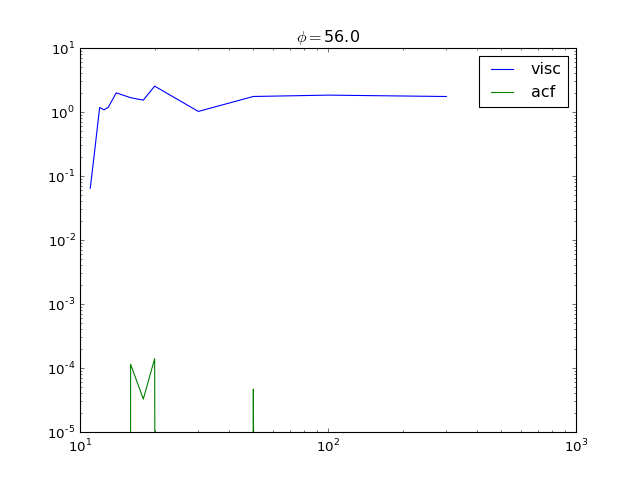

In [235]:
def get_viscosity(path):
    nu_file = pd.read_csv(path+"result/nu_t.dat")
    nu_vals = nu_file[nu_file.columns[2]][tmin:]
    return np.mean(nu_vals)

acf_area = [np.array(area_under_curves[1][i])/float(area_under_curves[0][i].split('yd')[-1].split('/')[0]) \
                        for i in range(len(area_under_curves[1]))]

print area_under_curves[0]
print acf_area
print [get_viscosity(p) for p in area_under_curves[0]]
ydvals = [float(area_under_curves[0][i].split('yd')[-1].split('/')[0]) for i in range(len(area_under_curves[1]))]
plt.figure()
plt.plot(ydvals,[get_viscosity(p) for p in area_under_curves[0]],label="visc")
plt.plot(ydvals,acf_area,label="acf")
plt.yscale("log")
plt.xscale("log")
plt.legend(loc='best')
plt.title("$\phi=$"+str(float(area_under_curves[0][-1].split('phi')[-1].split('_')[0])))
plt.show()

In [257]:
from statsmodels.graphics.tsaplots import plot_acf

dataset = sp.reader.DataSet('rhor1_phi56_yd11.0',particles=True, fluid=False)
stress_on_particle = []
for i in tqdm(dataset.tlist[1::10]):
    dataset.load_state(i)
    stress_on_particle.append(np.mean(map(np.linalg.norm,dataset.particles.sshear_tot)))

100%|██████████| 101/101 [00:07<00:00, 13.97it/s]


<IPython.core.display.Javascript object>


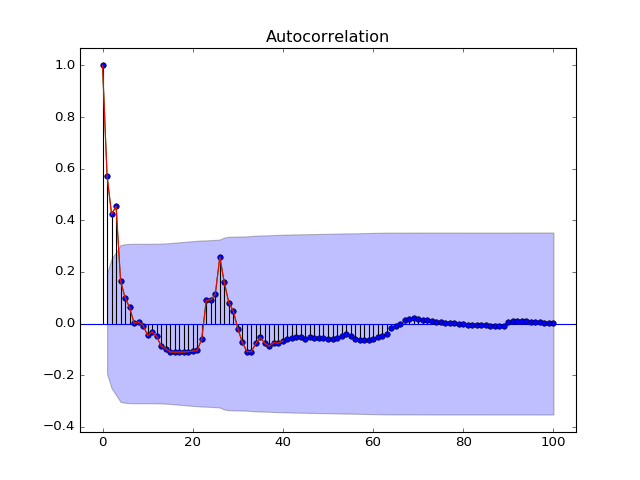

<IPython.core.display.Javascript object>


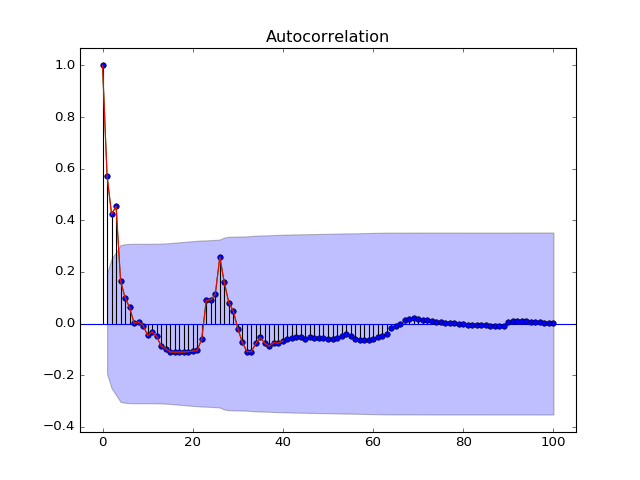

In [253]:
plot_acf(pd.Series(stress_on_particle))

<IPython.core.display.Javascript object>


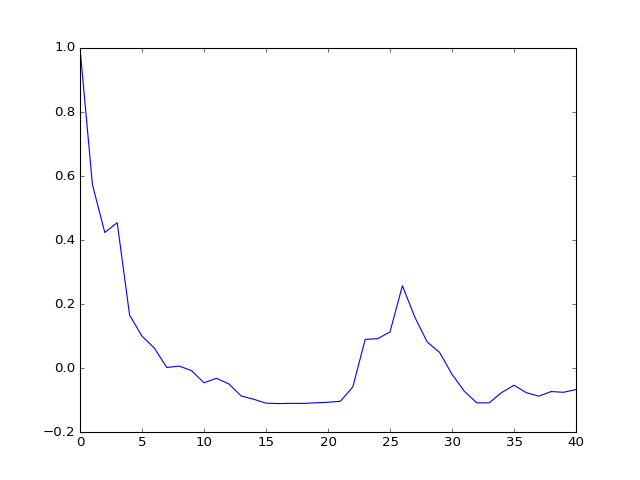

<IPython.core.display.Javascript object>


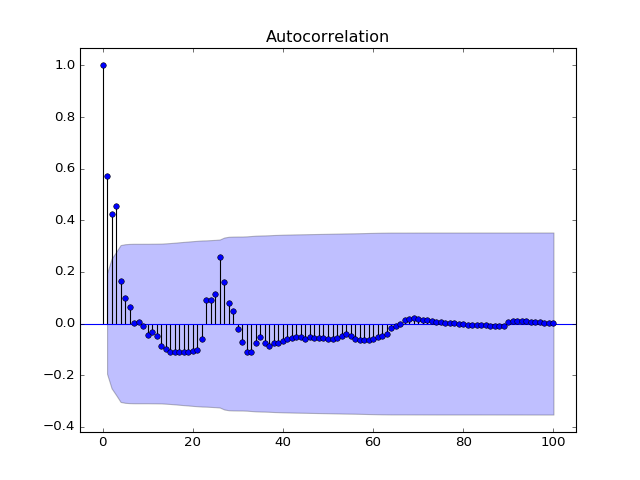

In [273]:
from statsmodels.tsa.stattools import acf
plt.figure()
plt.plot(acf(stress_on_particle))
plot_acf([i*200 for i in stress_on_particle])
plt.show()

In [274]:
acf?